Fixed Source MC code

In [8]:
import numpy as np
import numpy.random as round
import matplotlib.pyplot as plt

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [9]:
Cnat_total = np.loadtxt('cross_sections_Janis\\C\\Cnat_total.csv', delimiter=';',skiprows=3)
Cnat_scattering = np.loadtxt('cross_sections_Janis\\C\\Cnat_scattering.csv', delimiter=';', skiprows=3)

Fe_total = np.loadtxt('cross_sections_Janis\\Fe\\Fe_total.csv', delimiter=';',skiprows=3)
Fe_scattering = np.loadtxt('cross_sections_Janis\\Fe\\Fe_scattering.csv', delimiter=';', skiprows=3)

Onat_total = np.loadtxt('cross_sections_Janis\\O\\Onat_total.csv', delimiter=';',skiprows=3)
Onat_scattering = np.loadtxt('cross_sections_Janis\\O\\Onat_scattering.csv', delimiter=';', skiprows=3)

U238_total = np.loadtxt('cross_sections_Janis\\U238\\U238_total.csv', delimiter=';',skiprows=3)
U238_scattering = np.loadtxt('cross_sections_Janis\\U238\\U238_scattering.csv', delimiter=';', skiprows=3)
U238_fission = np.loadtxt('cross_sections_Janis\\U238\\U238_fission.csv', delimiter=';', skiprows=3)

U235_total = np.loadtxt('cross_sections_Janis\\U235\\U235_total.csv', delimiter=';',skiprows=3)
U235_scattering = np.loadtxt('cross_sections_Janis\\U235\\U235_scattering.csv', delimiter=';', skiprows=3)
U235_fission = np.loadtxt('cross_sections_Janis\\U235\\U235_fission.csv', delimiter=';', skiprows=3)

Create isotopes

In [10]:
carbon = mat_m.isotope(6,12,1.1E23,Cnat_total[:,0],Cnat_total[:,1],Cnat_scattering[:,1])
iron = mat_m.isotope(26,56,8.6E22,Fe_total[:,0],Fe_total[:,1],Fe_scattering[:,1])
uranium238 = mat_m.isotope(92,238,1.76E22,U238_total[:,0],U238_total[:,1],U238_scattering[:,1],U238_fission[:,1],2.5)
uranium235 = mat_m.isotope(92,235,4.4E21,U235_total[:,0],U235_total[:,1],U235_scattering[:,1],U235_fission[:,1],2.5)
#source = phy_m.source(GV.LL,100,GV.SOURCE_POSITION,1.,'watt')
source = phy_m.source(GV.LL,100,GV.SOURCE_POSITION,1.,'fixed')

Create materials

In [11]:
core_list = [carbon]
core = mat_m.material(core_list)
#reflector_list = [iron,carbon]
#reflector = mat_m.material(reflector_list)

Tally creation

In [12]:
#distribution = [(core,0,4),(reflector,4,5)]
distribution = [(core,0,0)]
domain = geo_m.domain(distribution,GV.LL,1000,GV.EE,1000,True)
tally = stat_m.tally(GV.LL,50)

Monte Carlo Code

In [13]:
while tally.iter <= GV.Nstories:
    # scelgo la particella da simulare
    nn = phy_c.choose_new_particle(source,1.,tally)
    while nn.eof > 0:
        nn.position = phy_c.sample_free_flight(nn,domain)
        if geo_c.is_outofbound(nn,'space'):
            nn.eof = 0
        else:
            stat_c.wellford(tally,nn,domain)
            # aggiorno i dati della particella dopo l'interazione
            nn.energy = phy_c.sample_energy_stepf(nn,domain)
            nn.direction = geo_m.direction.get_rnd_direction()
            nn.weight = phy_c.new_weight(nn,domain)
            # controllo l'energia
            if geo_c.is_outofbound(nn,'energy') is True:
                nn.eof = 0
            else:
                # russian roulette e splitting
                stat_c.russian_roulette(nn)
                stat_c.splitting(nn)

Results processing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


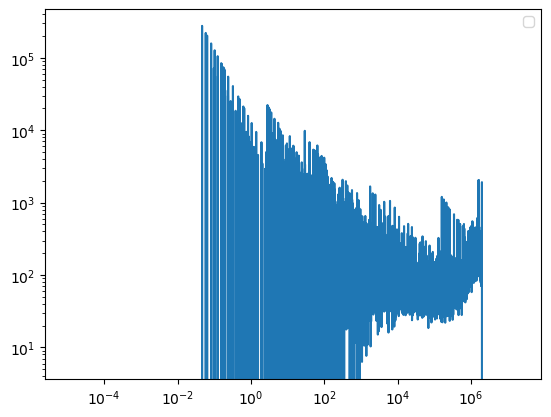

In [14]:
stat_c.normalization(tally)
avg = tally.avg
sigma = tally.sigma
jj = len(GV.Groups)
#for ii in range(len(avg)):
#    plt.errorbar(tally.energyrange[1:], avg[ii], yerr=sigma[ii], fmt='o', capsize=5)
#    plt.plot(tally.energyrange[1:],avg[ii], label='Group{}'.format(jj))
#    jj -= 1
#plt.xlabel('position [cm]')
#plt.ylabel(r'$\Phi$ [n/cm^3 s eV]')
plt.yscale('log')
plt.xscale('log')
plt.plot(tally.energyrange,avg)
plt.legend()
plt.show()